## Toymaker Example

### The Setup

An example of an idealized model for a manufacturing process. State $x=1$ is associated with the production of a successful toy and state $x=2$ is associated with the production of an unsuccessful toy. The four possible decisions represent the following actions:
\begin{align*}
    &u=1 \text{ no advertising and no research} \\
    &u=2 \text{ no advertising, but research} \\
    &u=3 \text{ advertising, but no research} \\
    &u=4 \text{ advertising and research}
\end{align*}

The inclusion of uncertainty in the state information corresponds to the case that the manufacturer does not know whether the toy currently being produced is going to be successful or not. The problem to solve is to maximize the profit over four steps:
\begin{equation*}
    \max \sum^4_{t=1} g(x_t, u(t))
\end{equation*}

The transition matrix, instantaneous cost function, and observation matrix are defined below:

In [1]:
import numpy as np
import sympy as sp

# Number of steps
N = 4

# Set of possible states
X= [0, 1]

# Set of possible controls
U=  [0, 1, 2, 3]

# Transition Matrix, P
P1 = [[0.5, 0.5],
      [0.4, 0.6]]
P2 = [[0.5, 0.5],
      [0.7, 0.3]]
P3 = [[0.8, 0.2],
      [0.4, 0.6]]
P4 = [[0.8, 0.2],
      [0.7, 0.3]]
P = np.array([P1, P2, P3, P4])

# Probability x is in a given state
w0 = sp.symbols('w0')
w1 = 1 - w0
W = [w0, w1]
        
# Instantaneous Cost Function, g(u, x, t) (independent of t)
g= [[20, -5],
    [17, -8],
    [10, -15],
    [7, -18]]
g = np.array(g)

# Observation Matrix, Q
Q= [[0.8, 0.2],
    [0.3, 0.7]]
Q = np.array(Q)

print(f'Transition Matrix, P: \n{P}\n')
print(f'Instantaneous Cost Function, g(u, x, t) (independent of t): \n{g}\n')
print(f'Observation Matrix, Q: \n{Q}')



Transition Matrix, P: 
[[[0.5 0.5]
  [0.4 0.6]]

 [[0.5 0.5]
  [0.7 0.3]]

 [[0.8 0.2]
  [0.4 0.6]]

 [[0.8 0.2]
  [0.7 0.3]]]

Instantaneous Cost Function, g(u, x, t) (independent of t): 
[[ 20  -5]
 [ 17  -8]
 [ 10 -15]
 [  7 -18]]

Observation Matrix, Q: 
[[0.8 0.2]
 [0.3 0.7]]


In [2]:
# Max Finder
def maximizer(expectation, eps=0.01):
    max = None
    argmax = []
    new_argmax = 0
    
    for i in np.arange(0,1+eps,eps):
        for u, eqn in enumerate(expectation):
            ans = eqn.subs(w0, i)
            if max == None:
                max = ans
                new_argmax = u

            if ans > max:
                max = ans
                new_argmax = u
        
        if len(argmax) == 0:
            argmax.append([new_argmax, i])

        if new_argmax != argmax[-1][0]:
            argmax.append([new_argmax, i])

    return argmax

def calc_z_j(W, u, j):
    z_j = []
    for i in X:
        z = Q[i,j]*np.dot(P[u,:,i],W[:])
        z = sp.nsimplify((z), tolerance=1e-10).evalf()
        z_j.append(z)
    return z_j

def calc_z_j_norm(z_j):
    norm = 0
    for i in X:
        norm += z_j[i]
    return norm

def V_k(W, k, eps=0.01, disp_results=False):
    if k == N:
        expectation = []
        for u in U:
            expectation.append(np.dot(g[u,:],W))
        argmax_u = maximizer(expectation)
        return [expectation[u[0]] for u in argmax_u], argmax_u
    
    expectation = []
    for u in U:
        sum = np.dot(g[u,:],W)
        sum_V = 0
        for j in X:
            Wk = []
            z_j = calc_z_j(W, u, j)
            z_j_norm = calc_z_j_norm(z_j)
            for i in X:
                Wk.append(z_j[i] / z_j_norm)
            
            sum_V += V_k(Wk, k+1)[0][0]*z_j_norm

        sum += sum_V
        expectation.append(sp.simplify(sp.nsimplify(sum, tolerance=1e-10)).evalf())

        if disp_results:
            print(f"u={u}", end="    ")
            print(expectation[u])

    argmax_u = maximizer(expectation, eps=eps)
    return [expectation[u[0]] for u in argmax_u], argmax_u

### To Solve
The value function is defined by
\begin{equation*}
    V_N=\min_u \underset{|\eta(N)}{\mathbb E} g(u, x_N, N)
\end{equation*}
From this, we get

\begin{equation*}
    V_4(w)=\max \mathbb E g(u,x_4)= 20 w_1(4) - 5 w_2(4)
\end{equation*}

In [3]:
# For t=4
V4, argmax4 = V_k(W, k=4)
print(f"V4(w) =    {V4[0]}")

V4(w) =    25*w0 - 5


In [4]:
# For t=3
V3, argmax3 = (V_k(W, k=3, disp_results=True))

print()
print(f"V3(w) =    {V3[0]},        w0 <= {argmax3[1][1]}")
print(f"           {V3[1]},              w0 >  {argmax3[1][1]}")

u=0    27.5*w0
u=1    20.0*w0 + 4.5
u=2    35.0*w0 - 10.0
u=3    27.5*w0 - 5.5

V3(w) =    20.0*w0 + 4.5,        w0 <= 0.6
           27.5*w0,              w0 >  0.6


In [5]:
# For t=2
V2, argmax2 = (V_k(W, k=2, eps=0.001, disp_results=True))

print()
print(f"V2(w) =    {V2[0]},    w0 <= {argmax2[1][1]}")
print(f"           {V2[1]},     w0 >  {argmax2[1][1]}")

u=0    27.375*w0 + 7.65
u=1    20.25*w0 + 11.775
u=2    34.5*w0 - 2.35
u=3    27.375*w0 + 1.775

V2(w) =    20.25*w0 + 11.775,    w0 <= 0.579
           27.375*w0 + 7.65,     w0 >  0.579


In [6]:
# For t=1
V1, argmax1 = (V_k(W, k=1, eps=0.001, disp_results=True))

print()
print(f"V1(w) =    {V1[0]},    w0 <= {argmax1[1][1]}")
print(f"           {V1[1]},    w0 >  {argmax1[1][1]}")

u=0    27.38875*w0 + 15.0925
u=1    20.2225*w0 + 19.25875
u=2    34.555*w0 + 5.0925
u=3    27.38875*w0 + 9.25875

V1(w) =    20.2225*w0 + 19.25875,    w0 <= 0.582
           27.38875*w0 + 15.0925,    w0 >  0.582


# Graphing the optimal value of the cost function

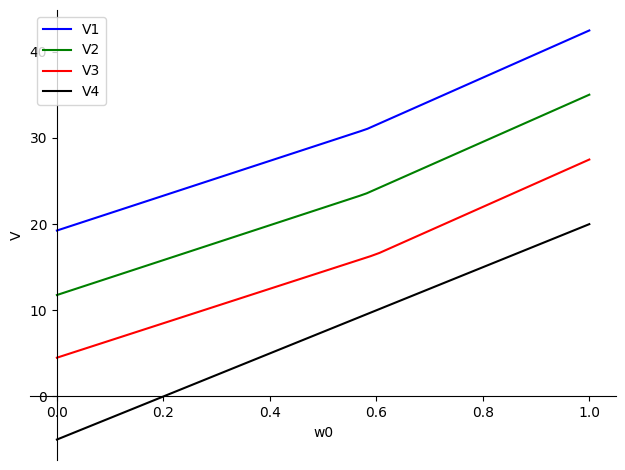

In [7]:
V1_pw = sp.Piecewise((V1[0], w0 <= argmax1[1][1]), (V1[1], w0 > argmax1[1][1]))
V2_pw = sp.Piecewise((V2[0], w0 <= argmax2[1][1]), (V2[1], w0 > argmax2[1][1]))
V3_pw = sp.Piecewise((V3[0], w0 <= argmax3[1][1]), (V3[1], w0 > argmax3[1][1]))

p = sp.plot((V1_pw, (w0, 0, 1)), line_color='blue', label='V1', show=False)
p.extend(sp.plot(V2_pw, (w0, 0, 1), line_color='green', label='V2', show=False))
p.extend(sp.plot(V3_pw, (w0, 0, 1), line_color='red', label='V3', show=False))
p.extend(sp.plot(V4[0], (w0, 0, 1), line_color='black', label='V4', show=False))

p.xlabel = 'w0'
p.ylabel = 'V'
p.legend = True
p.show()